# Predicting Bike Rentals

Many American cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

Here are the descriptions for the relevant columns:

    instant - A unique sequential ID number for each row
    
    dteday - The date of the rentals
    
    season - The season in which the rentals occurred
    
    yr - The year the rentals occurred
    
    mnth - The month the rentals occurred
    
    hr - The hour the rentals occurred
   
    holiday - Whether or not the day was a holiday
    
    weekday - The day of the week (as a number, 0 to 7)
    
    workingday - Whether or not the day was a working day
    
    weathersit - The weather (as a categorical variable)
    
    temp - The temperature, on a 0-1 scale
    
    atemp - The adjusted temperature
    
    hum - The humidity, on a 0-1 scale
    
    windspeed - The wind speed, on a 0-1 scale
    
    casual - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
    
    registered - The number of registered riders (people who had already signed up)
    
    cnt - The total number of bike rentals (casual + registered)

* Predict the total number of bikes people rented in a given hour. 
* Predict the cnt column using all of the other columns, except for casual and registered. 
* To accomplish this, create a few different machine learning models and evaluate their performance.

In [2]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# read data
bike_rentals = pd.read_csv('bike_rental_hour.csv')
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


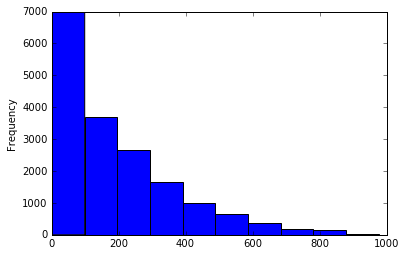

In [5]:
# histigram of cnt
bike_rentals['cnt'].plot(kind = 'hist')

In [7]:
# correlation features with cnt
bike_rentals.corr()['cnt'].sort_values()

hum          -0.322911
weathersit   -0.142426
holiday      -0.030927
weekday       0.026900
workingday    0.030284
windspeed     0.093234
mnth          0.120638
season        0.178056
yr            0.250495
instant       0.278379
hr            0.394071
atemp         0.400929
temp          0.404772
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

High correlation only with variables registred and casuual, which are logically  related

In [12]:
# create new categorical variable 'time_label'
# indicates ime of a day
def assign_label(h):
    if h in range(6,12): return '1'
    elif h in range(12,18): return '2'
    elif h in range(18,24): return '3'
    else: return '4' 
bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)
bike_rentals.pivot_table(index = ['time_label','hr'], values = 'cnt')

cnt
time_label hr            
1          6    76.044138
           7   212.064649
           8   359.011004
           9   219.309491
           10  173.668501
           11  208.143054
2          12  253.315934
           13  253.661180
           14  240.949246
           15  251.233196
           16  311.983562
           17  461.452055
3          18  425.510989
           19  311.523352
           20  226.030220
           21  172.314560
           22  131.335165
           23   87.831044
4          0    53.898072
           1    33.375691
           2    22.869930
           3    11.727403
           4     6.352941
           5    19.889819



#### Since cnt is continuous numeric data the most appropriate error metric is mean_squarred error

### Splitting the Data Into Train and Test Sets

In [13]:
# split ti train and test
train = bike_rentals.sample(frac = 0.8, random_state = 1)
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

### Applying Linear Regression

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse

In [15]:
# print all columns
bike_rentals.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt', 'time_label'],
      dtype='object')

In [17]:
# choosinf features
features = ['season', 'mnth', 'hr', 'holiday', 'weekday', 
            'temp', 'hum' , 'windspeed']

In [19]:
lr = LinearRegression()
lr.fit(train[features],train['cnt'])
prediction = lr.predict(test[features])
mse_lr = mse(prediction, test['cnt'])
print('mse: ',mse_lr)
print('rmse: ', mse_lr**0.5)

mse:  20867.28195472736
rmse:  144.455120901709


The error metric is relatively high. One of the problem is that most of the variables are categorical, and doesn't have any correlation with the target. So dependence is not linear, and linear regression is not suiteble approach

### Applying Decision Trees

In [20]:
from sklearn.tree import DecisionTreeRegressor

In [21]:
# fit model without parameters
dtr= DecisionTreeRegressor()
dtr.fit(train[features], train['cnt'])
prediction = dtr.predict(test[features])
mse_lr = mse(prediction, test['cnt'])
print('mse: ',mse_lr)
print('rmse: ', mse_lr**0.5)

mse:  9414.91326237054
rmse:  97.03047594632596


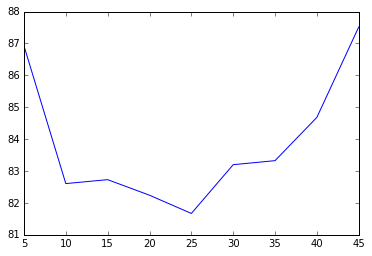

In [41]:
# fit model with different min_samples_leaf
param = []
for i in range(5,50,5):
    dtr= DecisionTreeRegressor(min_samples_leaf = i)
    dtr.fit(train[features], train['cnt'])
    prediction = dtr.predict(test[features])
    mse_lr = mse(prediction, test['cnt'])
    param.append(mse_lr**0.5)
plt.plot([x for x in range(5,50,5)], param)
plt.show()

the least error with min_samples_leaf = 25

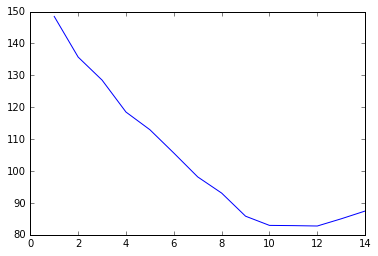

In [42]:
# fit model with different max_depth
param = []
for i in range(1,15):
    dtr= DecisionTreeRegressor(max_depth = i)
    dtr.fit(train[features], train['cnt'])
    prediction = dtr.predict(test[features])
    mse_lr = mse(prediction, test['cnt'])
    param.append(mse_lr**0.5)
plt.plot([x for x in range(1,15)], param)
plt.show()

the least error with max_depth = 11

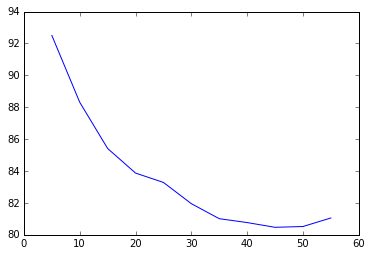

In [46]:
# fit model with different min_samples_split
param = []
for i in range(5,60,5):
    dtr= DecisionTreeRegressor(min_samples_split = i)
    dtr.fit(train[features], train['cnt'])
    prediction = dtr.predict(test[features])
    mse_lr = mse(prediction, test['cnt'])
    param.append(mse_lr**0.5)
plt.plot([x for x in range(5,60,5)], param)
plt.show()

the least error with min_samples_split = 45

In [47]:
# fit model with best parameters
dtr= DecisionTreeRegressor(min_samples_split = 45, max_depth = 11, min_samples_leaf = 25)
dtr.fit(train[features], train['cnt'])
prediction = dtr.predict(test[features])
mse_lr = mse(prediction, test['cnt'])
print('mse: ',mse_lr)
print('rmse: ', mse_lr**0.5)

mse:  6857.754758316375
rmse:  82.8115617430101


### Applying Random Forest
Random forests tend to be much more accurate than simple models like linear regression. Due to the way random forests are constructed, they tend to overfit much less than decision trees. Random forests can still be prone to overfitting, though, so it's important to tune parameters like maximum depth and minimum samples per leaf.

In [50]:
from sklearn.ensemble import RandomForestRegressor

In [52]:
# fit model
rfr= RandomForestRegressor()
rfr.fit(train[features], train['cnt'])
prediction = rfr.predict(test[features])
mse_lr = mse(prediction, test['cnt'])
print('mse: ',mse_lr)
print('rmse: ', mse_lr**0.5)

mse:  5306.475841100719
rmse:  72.84556157447562


even with default parameters rfr predicts much better

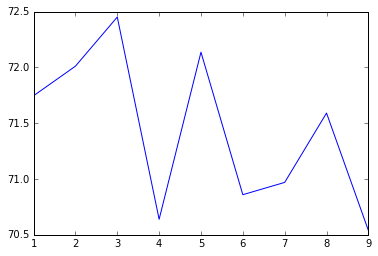

In [64]:
# fit model with differen min_samples_split
param = []
for i in range(1,10,1):
    rfr= RandomForestRegressor(min_samples_split = i)
    rfr.fit(train[features], train['cnt'])
    prediction = rfr.predict(test[features])
    mse_lr = mse(prediction, test['cnt'])
    param.append(mse_lr**0.5)
plt.plot([x for x in range(1,10,1)], param)
plt.show()

the least error with min_samples_split = 9, but it looks rather random

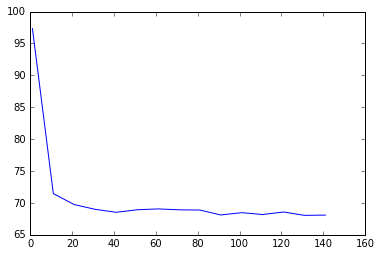

In [55]:
# fit model with differen min_samples_leaf
param = []
for i in range(1,150,10):
    rfr= RandomForestRegressor(n_estimators = i)
    rfr.fit(train[features], train['cnt'])
    prediction = rfr.predict(test[features])
    mse_lr = mse(prediction, test['cnt'])
    param.append(mse_lr**0.5)
plt.plot([x for x in range(1,150,10)], param)
plt.show()

after n_estimatore = 20, there is no significant change in error metric

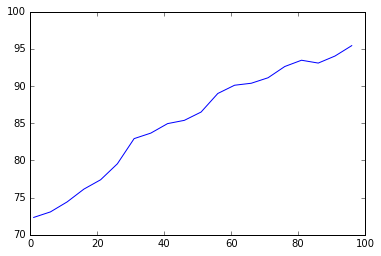

In [57]:
# fit model with differen min_samples_leaf
param = []
for i in range(1,100,5):
    rfr= RandomForestRegressor(min_samples_leaf = i)
    rfr.fit(train[features], train['cnt'])
    prediction = rfr.predict(test[features])
    mse_lr = mse(prediction, test['cnt'])
    param.append(mse_lr**0.5)
plt.plot([x for x in range(1,100,5)], param)
plt.show()

with raise in min_samples_leaf error only rises. 

In [68]:
# fit model with best params
rfr= RandomForestRegressor(min_samples_leaf = 1, n_estimators = 30)
rfr.fit(train[features], train['cnt'])
prediction = rfr.predict(test[features])
mse_lr = mse(prediction, test['cnt'])
print('mse: ',mse_lr)
print('rmse: ', mse_lr**0.5)

mse:  4819.06902656745
rmse:  69.41951473877825


With Random Forest algorithm we were able to decrease rmse from 144 to 69. Which is still rather big error for our data set.